# A VHTR geometry 
This notebook can be used as a template for modeling VHTR reactors.

In [1]:
%matplotlib inline
import openmc

In [2]:
# Materials definitions

fuel = openmc.Material(name='Fuel')
fuel.add_element('U', 1.0, enrichment=4.0)
fuel.add_nuclide('O16', 2.0)
fuel.set_density('g/cm3', 10.41)

buffer = openmc.Material(name='Buffer')
buffer.add_element('C', 1.0)
buffer.set_density('g/cm3', 0.95)
buffer.add_s_alpha_beta('c_Graphite')

IPyC = openmc.Material(name='Inner PyC')
IPyC.add_element('C', 1.0)
IPyC.set_density('g/cm3', 1.9)
IPyC.add_s_alpha_beta('c_Graphite')

SiC = openmc.Material(name = "SiC")
SiC.add_element("Si", 0.5)
SiC.add_element("C", 0.5)
SiC.set_density("g/cm3", 3.18)

OPyC = openmc.Material(name='Outer PyC')
OPyC.add_element('C', 1.0)
OPyC.set_density('g/cm3', 1.9)
OPyC.add_s_alpha_beta('c_Graphite')

graphite = openmc.Material(name='Graphite')
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 1.7)
graphite.add_s_alpha_beta('c_Graphite')

helium = openmc.Material(name='Helium')
helium.add_element('He', 1.0)
helium.set_density('g/cm3', 0.000166)

b4c = openmc.Material(name='B4C Poison')
b4c.add_element('B', 4.0, enrichment=18.7, enrichment_target='B10', enrichment_type='wo')
b4c.add_element('C', 1.0)
b4c.set_density('g/cm3', 1.82)

# Instantiate a Materials collection and export to xml
materials_list = [fuel, buffer, IPyC, SiC, OPyC, graphite, helium, b4c]
materials_file = openmc.Materials(materials_list)
materials_file.export_to_xml()

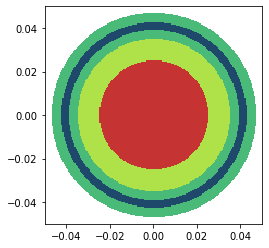

In [3]:
# Geometry definitions for TRISO particles

kernelsph = openmc.Sphere(r=250e-4)
buffsph = openmc.Sphere(r=350e-4)
IPyCsph = openmc.Sphere(r=390e-4)
SiCsph = openmc.Sphere(r=425e-4)
OPyCsph = openmc.Sphere(r=470e-4)

layers = [kernelsph, buffsph, IPyCsph, SiCsph, OPyCsph]
triso_mats = [fuel, buffer, IPyC, SiC, OPyC]
triso_cells = []
for i in range(5):
  if (i == 0):
    triso_cells.append(openmc.Cell(fill=triso_mats[0], region=-layers[0]))
  else:
    triso_cells.append(openmc.Cell(fill=triso_mats[i], region=+layers[i-1] & -layers[i]))

triso_universe = openmc.Universe(cells=triso_cells)
triso_colors = {triso_cells[0]: (0.78, 0.2, 0.2), triso_cells[1]: (0.69, 0.89, 0.29), 
                triso_cells[2]: (0.29, 0.73, 0.47), triso_cells[3]: (0.12, 0.29, 0.42), 
                triso_cells[4]: (0.29, 0.73, 0.47)}
triso_universe.plot(width = (0.1, 0.1), colors = triso_colors)

In [4]:
print(triso_cells)

[Cell
	ID             =	1
	Name           =	
	Fill           =	Material 1
	Region         =	-1
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	2
	Name           =	
	Fill           =	Material 2
	Region         =	(1 -2)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	3
	Name           =	
	Fill           =	Material 3
	Region         =	(2 -3)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	4
	Name           =	
	Fill           =	Material 4
	Region         =	(3 -4)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	5
	Name           =	
	Fill           =	Material 5
	Region         =	(4 -5)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
]


In [5]:
# Generating TRISO particle lattice in cylindrical pin cell

cylsurf = openmc.ZCylinder(r=0.6225)
maxz = openmc.ZPlane(z0=1.95, boundary_type='reflective')
minz = openmc.ZPlane(z0=-1.95, boundary_type='reflective')

lattice_region = -cylsurf & -maxz & +minz
triso_outer_radius = 465e-4
spheres = openmc.model.pack_spheres(radius=triso_outer_radius, region=lattice_region, pf=0.3)

In [6]:
triso_particles = [openmc.model.TRISO(triso_outer_radius, fill=triso_universe, center=c) for c in spheres]

In [8]:
vol_triso = 4/3 * 3.14 * triso_outer_radius**3 * len(triso_particles)
actual_pf = vol_triso/(3.14 * (0.6225) ** 2 * 3.9)

In [9]:
lattice_cell = openmc.Cell(region=lattice_region)
lower_left, upp_right = lattice_cell.region.bounding_box
shape = (4, 4, 4)
pitch = (upp_right - lower_left)/shape
triso_latt = openmc.model.create_triso_lattice(triso_particles, lower_left, pitch, shape, graphite)
lattice_cell.fill = triso_latt

lattice_universe = openmc.Universe(cells=[lattice_cell])

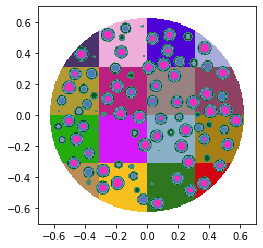

In [10]:
lattice_universe.plot(width=(1.4,1.4))

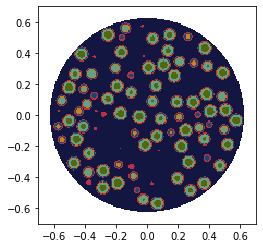

In [11]:
lattice_universe.plot(width=(1.4,1.4), color_by='material', colors = {graphite: (0.08, 0.09, 0.26)})

**Testing Pin Cell Embedded In Graphite Block**

In [12]:
hexaregion = openmc.model.hexagonal_prism(edge_length = 0.85, orientation = 'x', boundary_type='reflective')

outer_region = hexaregion & +cylsurf & -maxz & +minz
outer_pin_cell = openmc.Cell(fill=graphite, region = outer_region)

In [13]:
pin_cell_universe = openmc.Universe(cells=[lattice_cell, outer_pin_cell])

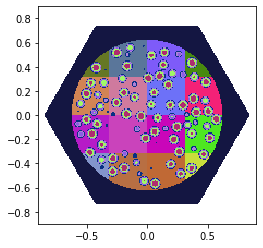

In [14]:
pin_cell_universe.plot(width=(1.8, 1.8), color_by='cell', colors = {outer_pin_cell: (0.08, 0.09, 0.26)})

As expected, the outside hexagonal block and the non-triso area of the pin cell are both filled with graphite:

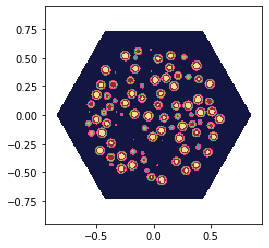

In [15]:
pin_cell_universe.plot(width=(1.9, 1.9), color_by='material', colors = {graphite: (0.08, 0.09, 0.26), fuel: (1, 0.86, 0.57)})

In [16]:
geom = openmc.Geometry(pin_cell_universe)
geom.export_to_xml()

**Creating Coolant Channels/Cells (Helium fill)**

In [19]:
small_coolant_surf = openmc.ZCylinder(r=0.6375)
big_coolant_surf = openmc.ZCylinder(r=0.79375)

small_coolant_cell = openmc.Cell(region=-small_coolant_surf & -maxz & +minz, fill=helium)
big_coolant_cell = openmc.Cell(region=-big_coolant_surf & -maxz & +minz, fill=helium)

outside_small_cell = openmc.Cell(region=+small_coolant_surf & -maxz & +minz, fill=graphite)
outside_big_cell = openmc.Cell(region=+big_coolant_surf & -maxz & +minz, fill=graphite)

small_coolant_universe = openmc.Universe(cells=[small_coolant_cell, outside_small_cell])
big_coolant_universe = openmc.Universe(cells=[big_coolant_cell, outside_big_cell])

**Burnable Poison Rod Geometry**

In [20]:
poison_surf = openmc.ZCylinder(r=0.6375)
poison_cell = openmc.Cell(region=-poison_surf & -maxz & +minz, fill=b4c)
outside_poison_cell = openmc.Cell(region=+poison_surf & -maxz & +minz, fill=graphite)

poison_universe = openmc.Universe(cells=[poison_cell, outside_poison_cell])

**Defining Material Outside Pin Cell For Use in Assemblies**

In [21]:
outer_pin_region = +cylsurf & -maxz & +minz
outer_pin_cell = openmc.Cell(fill=graphite, region=outer_pin_region)

total_pin_cell_universe = openmc.Universe(cells=[lattice_cell, outer_pin_cell])

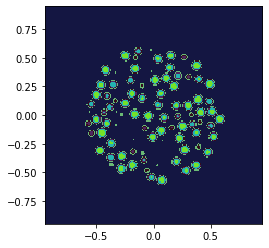

In [22]:
total_pin_cell_universe.plot(width=(1.9, 1.9), color_by='material', colors = {graphite: (0.08, 0.09, 0.26)})

**Constructing Geometry of Hexagonal Fuel Assembly**

In [23]:
outer_graphite_cell = openmc.Cell(fill=graphite)
outer_graphite_universe = openmc.Universe(cells=[outer_graphite_cell])

In [24]:
assemblylat = openmc.HexLattice(name="Assembly")
assemblylat.outer = outer_graphite_universe
assemblylat.pitch = (1.9,)
assemblylat.center = (0.0, 0.0)
assemblylat.orientation = 'x'

In [25]:
def repeat_lat_element(n, pad_left, pad_right):
  ring = []
  for i in range(6):
    ring += pad_left
    for i in range(n):
      ring.extend([total_pin_cell_universe]*2 + [big_coolant_universe])
    ring += pad_right

  return ring

In [26]:
def build_outer_ring(n, insert_poison_rod):
  REPEAT_SECTION = 2
  ring = []

  # burnable poison rods sides
  poisonring = []
  poisonring += [insert_poison_rod] + [total_pin_cell_universe] + [big_coolant_universe]
  for i in range(REPEAT_SECTION):
      poisonring.extend([total_pin_cell_universe]*2 + [big_coolant_universe])
  poisonring += [total_pin_cell_universe]

  # normal sides
  base = []
  base += [outer_graphite_universe] + [total_pin_cell_universe] + [big_coolant_universe]
  for i in range(REPEAT_SECTION):
      base.extend([total_pin_cell_universe]*2 + [big_coolant_universe])
  base += [total_pin_cell_universe]

  ring.extend(poisonring * n + base * (6 - n))

  return ring

In [27]:
def build_all_rings(insert_poison_rod):
  rings = []

  outer_ring = build_outer_ring(2, insert_poison_rod)
  rings.append(outer_ring)

  for i in range(1, 8): # rings 1 through 7
    ring_left = []
    ring_right = []
    if (i % 3 == 1):
      ring_left = [big_coolant_universe]
      ring_right = [total_pin_cell_universe]*2
    elif (i % 3 == 2):
      ring_left = [total_pin_cell_universe] + [big_coolant_universe]
    else:
      ring_right = [total_pin_cell_universe]

    n = 0
    if (i <= 3):
      n = 2
    elif (i <= 6):
      n = 1
    else:
      n = 0
    
    cur_ring = repeat_lat_element(n, ring_left, ring_right)
    rings.append(cur_ring)

  inner_ring = []
  for i in range(6):
    inner_ring.extend([total_pin_cell_universe] + [small_coolant_universe])
  rings.append(inner_ring)
  rings.append([outer_graphite_universe]*6)
  rings.append([outer_graphite_universe])

  return rings

In [28]:
rings = build_all_rings(poison_universe)
assemblylat.universes = rings

In [30]:
assembly_surf = openmc.model.hexagonal_prism(edge_length=21, orientation='x', boundary_type='reflective')
assembly_cell = openmc.Cell(fill=assemblylat, region=assembly_surf & +minz & -maxz)
assembly_universe = openmc.Universe(cells=[assembly_cell])

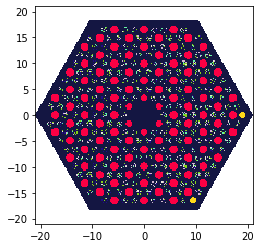

In [31]:
assembly_universe.plot(width=(42, 42), color_by='material', colors={helium: (0.99, 0, 0.27), graphite: (0.08, 0.09, 0.26), b4c:  (1, 0.85, 0.1)})

In [32]:
geom = openmc.Geometry(assembly_universe)
geom.export_to_xml()

In [34]:
# OpenMC simulation parameters

batches = 100
inactive = 10
particles = 5000

settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

bounds = [-5, -5, -0.63, 5, 5, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

settings_file.export_to_xml()